<a href="https://colab.research.google.com/github/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/main/TEMPLATE_Probabilistic_Machine_Learning_Project_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilistic Machine Learning - Project Report

**Course:** Probabilistic Machine Learning (SoSe 2025)
**Lecturer:** Dr. Alvaro Diaz-Ruelas  
**Student(s) Name(s):**  Jeremias Fichtner
**GitHub Username(s):**  Jeremoya
**Date:**  09/06/2025
**PROJECT-ID:** 16-1FJXXXX_time_series_vegetation

---


## 1. Introduction

#### Brief description of the dataset and problem

The dataset is remotely sensed time series data consisting of time series for **5 different variables** (air temperature, evaporation, precipitation, radiation, kNDVI (Kernel Normalized Difference Vegetation Index, (https://doi.org/10.1126/sciadv.abc7447))) which has been collected for approximately **280'000 pixels** over a time span of **21 years** in **intervalls of 8 days**, which makes for a total of **1004 timesteps** (shape: [280'000, 1004, 5] with the dimensions [pixel,  time, variable]). The data is shuffled so that no spatial information is retained, only temporal. The goal is to make a timeseries prediction on the kNDVI variable using one or multiple models and to to assess its quality. There is also a small subset of the data where the kNDVI was not collected, and for this the missing values could be added, given a sufficient performance of the model.

#### Motivation for your project

I am generally interested and also have some work experience in remote sensing, but so far more tree oriented and in a typical classification context, which is why I think doing a different project could be quite interesting.
Viewed from a broader perspective, vegetation indices and their prediction is a useful topic in general. The kNDVI  is a metric used to monitor vegetation using spectral remote sensing, which generalizes the traditional NDVI (https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) by using kernel methods. It has possible applications in vegetation and biodiversity monitoring, climate change, as well as agriculture. Time Series prediction is very interesting because it does not just exploit relations between different variables, but also draws information from temporal auto-correlations in the form of seasonally reoccurring patterns. If a good prediction accuracy could be achieved, approximates for the kNDVI could be drawn by just collecting other input information. This is important in case of missing satellite data, which could be caused by cloud coverage for example.


## 2. Data Loading and Exploration






In [2]:
import numpy as np

# small sample of 100 pixels, including all 1004 timesteps for all 5 variables.

data_sample = np.load("data/data_reduced.npz")["data"]
data_sample.shape

(100, 1004, 5)

In [3]:
# check for NANs

np.isnan(np.sum(data_sample))

np.False_

Lets first take a basic glance at some timeseries. Here, normalized values are plotted for all variables for the last 23 timesteps, which roughly equals half a year.

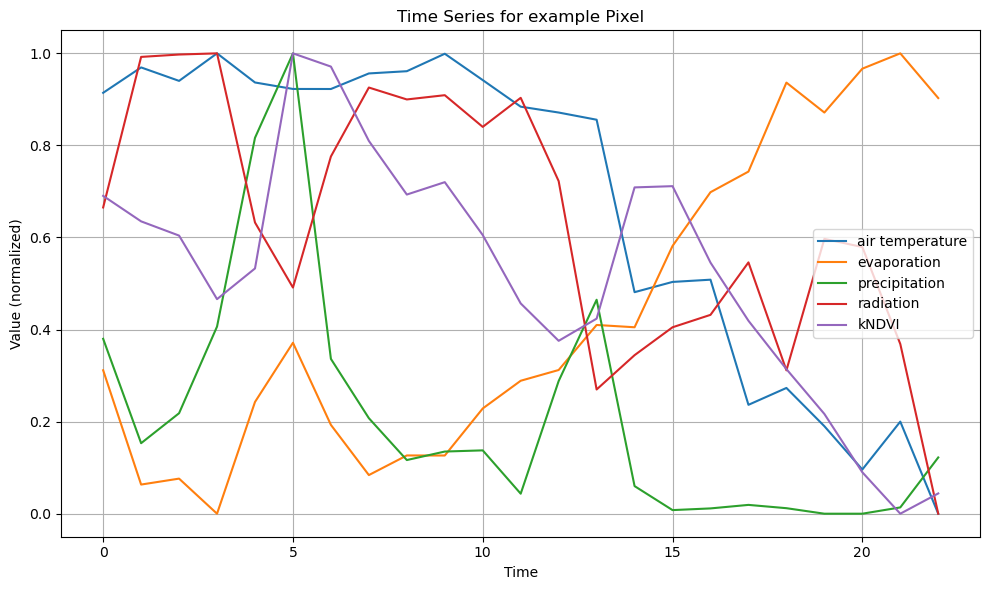

In [4]:
import matplotlib.pyplot as plt

example_series = data_sample[0,-23:,:]
normalized = (example_series - example_series.min(axis=0)) / (example_series.max(axis=0) - example_series.min(axis=0))
time = np.arange(0,23)

vars = ["air temperature", "evaporation", "precipitation", "radiation", "kNDVI"]

plt.figure(figsize=(10, 6))
for var in range(normalized.shape[1]):
    plt.plot(time, normalized[:, var], label=vars[var])


plt.xlabel('Time')
plt.ylabel('Value (normalized)')
plt.title(f'Time Series for example Pixel')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Nothing really clear to be seen here. In the next set, the timeseries for the kNDVI is plotted for each year separately and overlaid. We hope to see an overlap as an indicator for seasonality

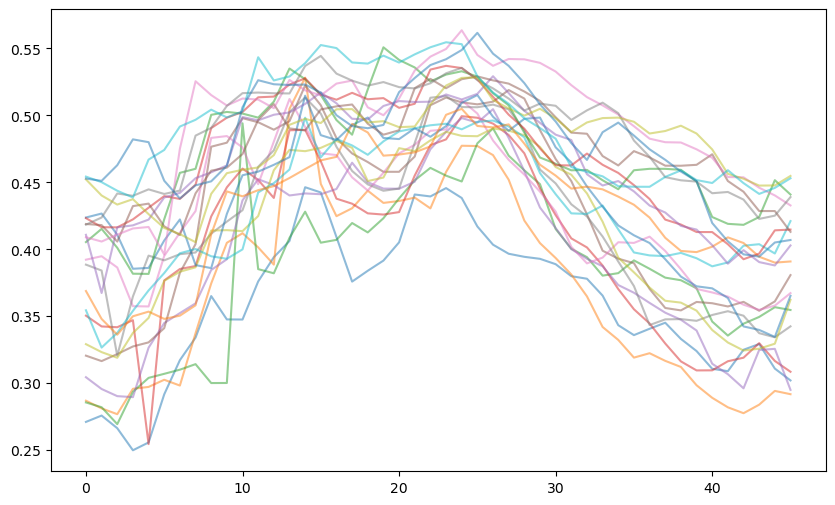

In [5]:
series = data_sample[0, :, 4]

period = 46
n_seasons = series.shape[0] // period

reshaped = series[:n_seasons * period].reshape(n_seasons, period)
reshaped.shape

plt.figure(figsize=(10, 6))
for season in reshaped:
    plt.plot(season, alpha=0.5)

The overlap hints at seasonality so in the next step, we will look at the autocorrelation function (ACF) for stronger patterns. For that the function is plotted for the last 92 timesteps of a pixel, which roughly equals 2 years.

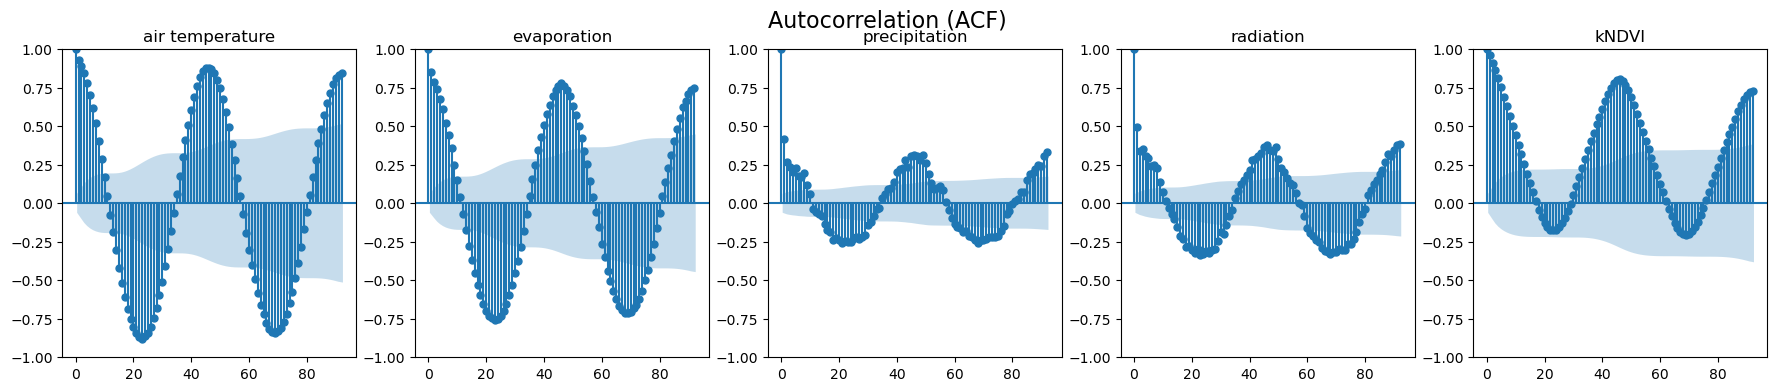

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

n_vars = data_sample.shape[2]

fig, axs = plt.subplots(1, n_vars, figsize=(22, 4))  

for var in range(n_vars):
    series = data_sample[0, :, var]
    plot_acf(series, ax=axs[var], lags=92, title=f'{vars[var]}')

plt.suptitle(f'Autocorrelation (ACF)', fontsize=16)
 
plt.show()

Some seasonal patterns seem to emerge. For all variables, there seems to be a yearly cycle judging by the wave form of the function and the high correlation with values at approximately 46 and 92 timesteps, which are 1 and 2 years time. All values also seem to be correlated with their immediate predecessors, although this is a little noisy in the precipitation and radiation variable. That intuitively makes sense, as precipitation for example usually can be linked to preoccurrences ("Rain yesterday is a good indicator for rain today"), but is also strongly influenced by many other factors, whereas a green tree (kNDVI) usually is not that volatile in its signal. We can do a seasonal trend decomposition using Loess (STL) to further investigate the seasonal patterns:

Text(0.5, 1.0, 'Seasonal Decomposition: precipitation')

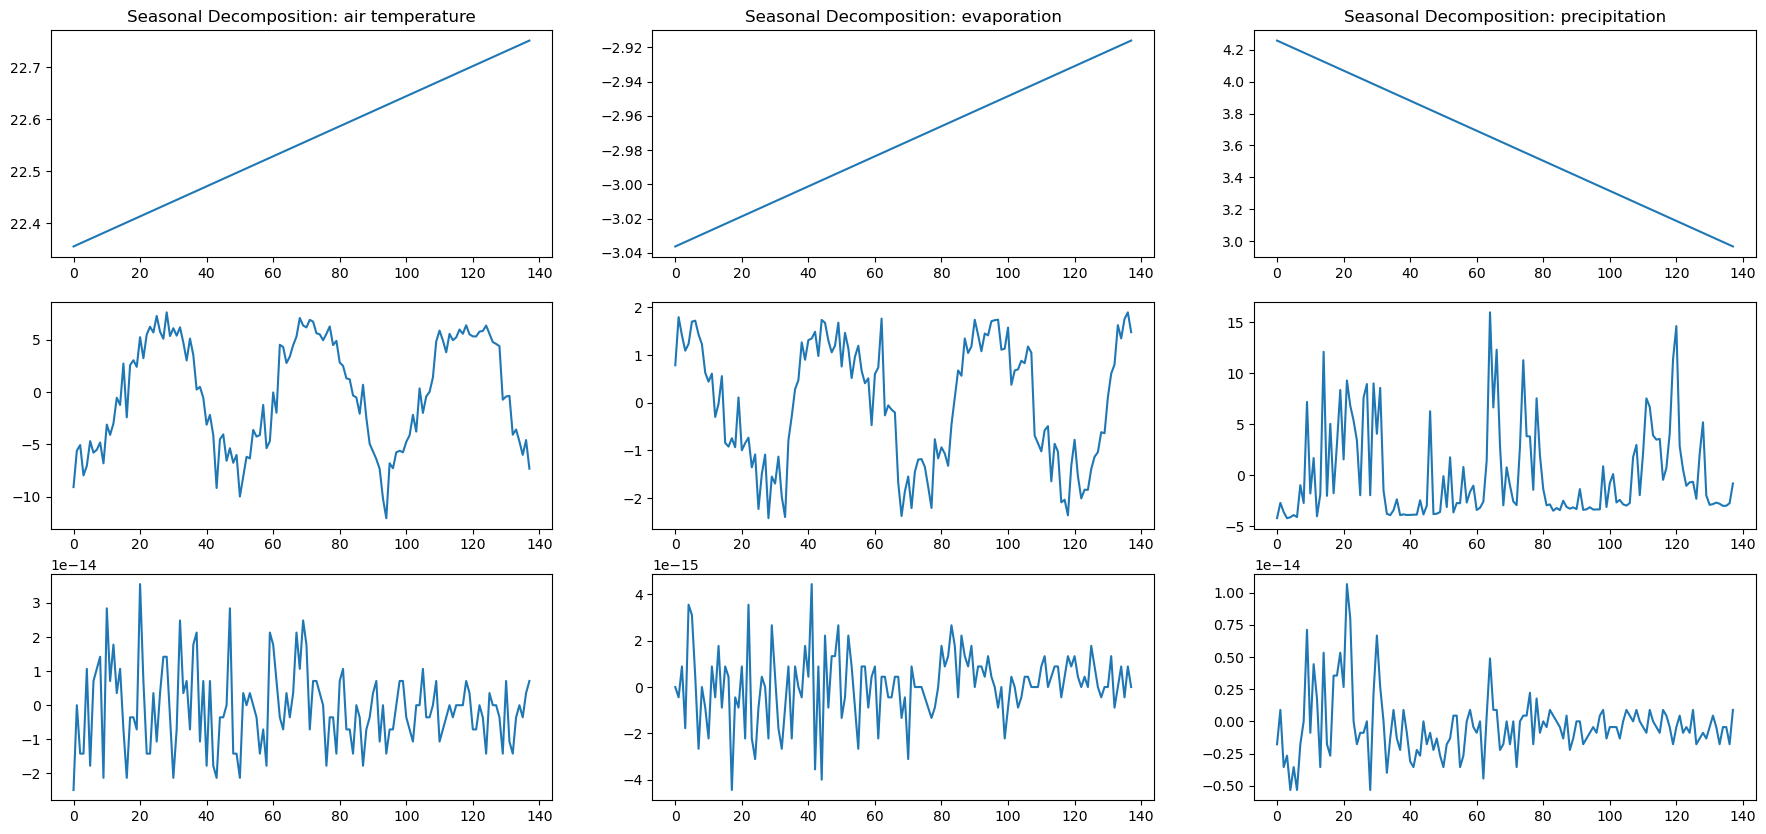

In [7]:
from statsmodels.tsa.seasonal import STL

fig, axs = plt.subplots(3, 3, figsize=(22, 10))  

for var in range(3):
    series = data_sample[0, -138:, var]
    stl = STL(series, period=92)  # replace with your expected season length
    res = stl.fit()
    axs[0, var].plot(res.trend)
    axs[1, var].plot(res.seasonal)
    axs[2, var].plot(res.resid)

axs[0, 0].set_title(f"Seasonal Decomposition: {vars[0]}")
axs[0, 1].set_title(f"Seasonal Decomposition: {vars[1]}")
axs[0, 2].set_title(f"Seasonal Decomposition: {vars[2]}")




This further confirms the assumption for seasonal patterns, which are more pronounced in variables like air temperature and evaporation and more noisy in precipitation for example. As a last exploratory measure, we can do a spectral analysis through a fourier tranformation, where we transform the data from the temporal to the spectral domain. This can just be a good general indicator for dominant cycles. 

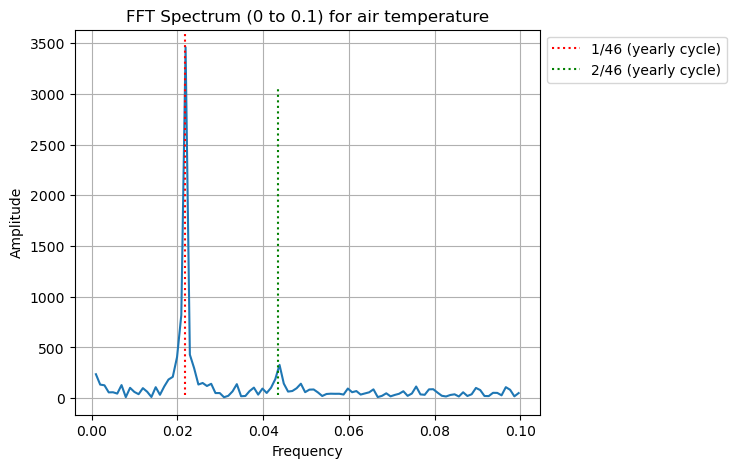

In [16]:
from scipy.fft import fft, fftfreq

series = data_sample[0, :, 0]
n = len(series)
fft_vals = np.abs(fft(series - np.mean(series)))  
freqs = fftfreq(n)


pos_mask = freqs > 0
freqs = freqs[pos_mask]
fft_vals = fft_vals[pos_mask]

range_mask = freqs <= 0.1
freqs_plot = freqs[range_mask]
fft_plot = fft_vals[range_mask]


plt.figure(figsize=(6, 5))
plt.plot(freqs_plot, fft_plot)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title(f"FFT Spectrum (0 to 0.1) for {vars[0]}")
plt.grid(True)
plt.axvline(x=1/46, color="r", ymin=0.05, ymax=1, ls=":", label="1/46 (yearly cycle)")
plt.axvline(x=1/23, color="g", ymin=0.05, ymax=0.85, ls=":", label="2/46 (yearly cycle)")
plt.legend(bbox_to_anchor=(1.0, 1), loc="upper left")
plt.show()


Again, a clear peak is visible at the yearly mark and another small one for the two year mark, so the seasonality assumption is confirmed further.


## 3. Data Preprocessing

- Steps taken to clean or transform the data




## 4. Probabilistic Modeling Approach

- Description of the models chosen
- Why they are suitable for your problem
- Mathematical formulations (if applicable)



## 5. Model Training and Evaluation

- Training process
- Model evaluation (metrics, plots, performance)
- Cross-validation or uncertainty quantification



## 6. Results

- Present key findings
- Comparison of models if multiple approaches were used



## 7. Discussion

- Interpretation of results
- Limitations of the approach
- Possible improvements or extensions



## 8. Conclusion

- Summary of main outcomes



## 9. References

- Cite any papers, datasets, or tools used